In [1]:
import cv2
import numpy as np
import pyrealsense2 as rs

import matplotlib.pyplot as plt

In [2]:
width, height = (640, 480)
framerate = 30

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 
    width, height, rs.format.z16, framerate)
config.enable_stream(rs.stream.color, 
    width, height, rs.format.bgr8, framerate)

In [8]:
pipeline.start(config)
# try:
while True:
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    if not depth_frame or not color_frame:
        continue

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())

    # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.1), cv2.COLORMAP_JET)
    images = np.hstack((color_image, depth_colormap))

    # Show images
    cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('RealSense', images)
    cv2.waitKey(1)
        
# finally:

#     # Stop streaming
#     pipeline.stop()

KeyboardInterrupt: 

In [9]:
profile = pipeline.get_active_profile()

In [13]:
depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
depth_intrinsics = depth_profile.get_intrinsics()
w, h = depth_intrinsics.width, depth_intrinsics.height

In [20]:
class AppState:
    def __init__(self, *args, **kwargs):
        self.WIN_NAME = 'RealSense'
        self.pitch, self.yaw = np.radians(-10), np.radians(-15)
        self.translation = np.array([0, 0, -1], dtype=np.float32)
        self.distance = 2
        self.prev_mouse = 0, 0
        self.mouse_btns = [False, False, False]
        self.paused = False
        self.decimate = 1
        self.scale = True
        self.color = True

    def reset(self):
        self.pitch, self.yaw, self.distance = 0, 0, 2
        self.translation[:] = 0, 0, -1

    @property
    def rotation(self):
        Rx, _ = cv2.Rodrigues((self.pitch, 0, 0))
        Ry, _ = cv2.Rodrigues((0, self.yaw, 0))
        return np.dot(Ry, Rx).astype(np.float32)

    @property
    def pivot(self):
        return self.translation + np.array((0, 0, self.distance), dtype=np.float32)

In [30]:
state = AppState()
pc = rs.pointcloud()

In [23]:
decimate = rs.decimation_filter()

In [25]:
decimate.set_option(rs.option.filter_magnitude, 2 ** state.decimate)
colorizer = rs.colorizer()

In [26]:
depth_colormap = np.asanyarray(
            colorizer.colorize(depth_frame).get_data())

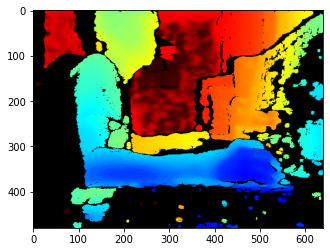

In [28]:
plt.imshow(depth_colormap)

In [31]:
points = pc.calculate(depth_frame)

In [34]:
mapped_frame, color_source = color_frame, color_image

In [36]:
pc.map_to(mapped_frame)

In [37]:
v, t = points.get_vertices(), points.get_texture_coordinates()
verts = np.asanyarray(v).view(np.float32).reshape(-1, 3)  # xyz
texcoords = np.asanyarray(t).view(np.float32).reshape(-1, 2)  # uv

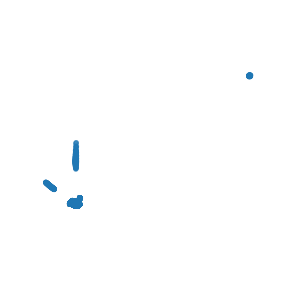

In [42]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2])
ax.set_axis_off()
plt.show()

In [1]:
import trimesh
mesh = trimesh.load("../out.ply")
mesh.show()